##Supermart Grocery Sales - ML Project

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
#Load dataset
data = pd.read_csv('Supermart Grocery Sales - Retail Analytics Dataset.csv')

# Display the first few rows of the dataset
print(data.head())

  Order ID Customer Name          Category      Sub Category         City  \
0      OD1        Harish      Oil & Masala           Masalas      Vellore   
1      OD2         Sudha         Beverages     Health Drinks  Krishnagiri   
2      OD3       Hussain       Food Grains      Atta & Flour   Perambalur   
3      OD4       Jackson  Fruits & Veggies  Fresh Vegetables   Dharmapuri   
4      OD5       Ridhesh       Food Grains   Organic Staples         Ooty   

   Order Date Region  Sales  Discount  Profit       State  
0  11-08-2017  North   1254      0.12  401.28  Tamil Nadu  
1  11-08-2017  South    749      0.18  149.80  Tamil Nadu  
2  06-12-2017   West   2360      0.21  165.20  Tamil Nadu  
3  10-11-2016  South    896      0.25   89.60  Tamil Nadu  
4  10-11-2016  South   2355      0.26  918.45  Tamil Nadu  


##Data Preprocessing

In [3]:
#Check for missing values
print(data.isnull().sum())

# Drop any rows with missing values
data.dropna(inplace=True)

# Check for duplicates
data.drop_duplicates(inplace=True)

Order ID         0
Customer Name    0
Category         0
Sub Category     0
City             0
Order Date       0
Region           0
Sales            0
Discount         0
Profit           0
State            0
dtype: int64


In [4]:
#Convert 'Order Date' to datetime format
data['Order Date'] = pd.to_datetime(data['Order Date'], errors='coerce')

# Extract day, month, and year from 'Order Date'
data['Order Day'] = data['Order Date'].dt.day
data['Order Month'] = data['Order Date'].dt.month
data['Order Year'] = data['Order Date'].dt.year

In [5]:
#Initialize the label encoder
le = LabelEncoder()

# Encode categorical variables
categorical_cols = ['Category', 'Sub Category', 'City', 'Region', 'State']

for col in categorical_cols:
    data[col] = le.fit_transform(data[col])

# Display the first few rows after encoding
print(data.head())

  Order ID Customer Name  Category  Sub Category  City Order Date  Region  \
0      OD1        Harish         5            14    21 2017-11-08       2   
1      OD2         Sudha         1            13     8 2017-11-08       3   
2      OD3       Hussain         3             0    13 2017-06-12       4   
3      OD4       Jackson         4            12     4 2016-10-11       3   
4      OD5       Ridhesh         3            18    12 2016-10-11       3   

   Sales  Discount  Profit  State  Order Day  Order Month  Order Year  
0   1254      0.12  401.28      0        8.0         11.0      2017.0  
1    749      0.18  149.80      0        8.0         11.0      2017.0  
2   2360      0.21  165.20      0       12.0          6.0      2017.0  
3    896      0.25   89.60      0       11.0         10.0      2016.0  
4   2355      0.26  918.45      0       11.0         10.0      2016.0  


##Exploratory Data Analysis (EDA)

/tmp/ipython-input-6-279985447.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='Sales', data=data, palette='Set2')


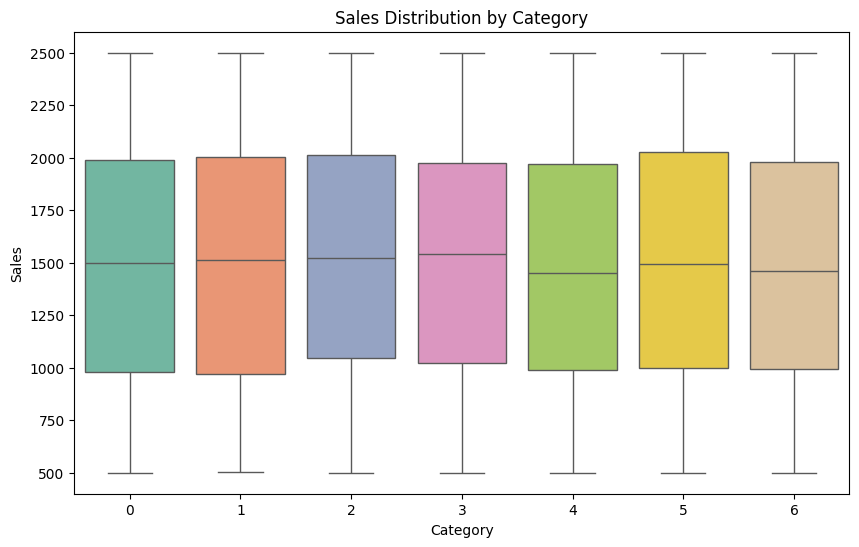

In [6]:
# Distribution of Sales by Category

plt.figure(figsize=(10, 6))
sns.boxplot(x='Category', y='Sales', data=data, palette='Set2')
plt.title('Sales Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Sales')
plt.show()

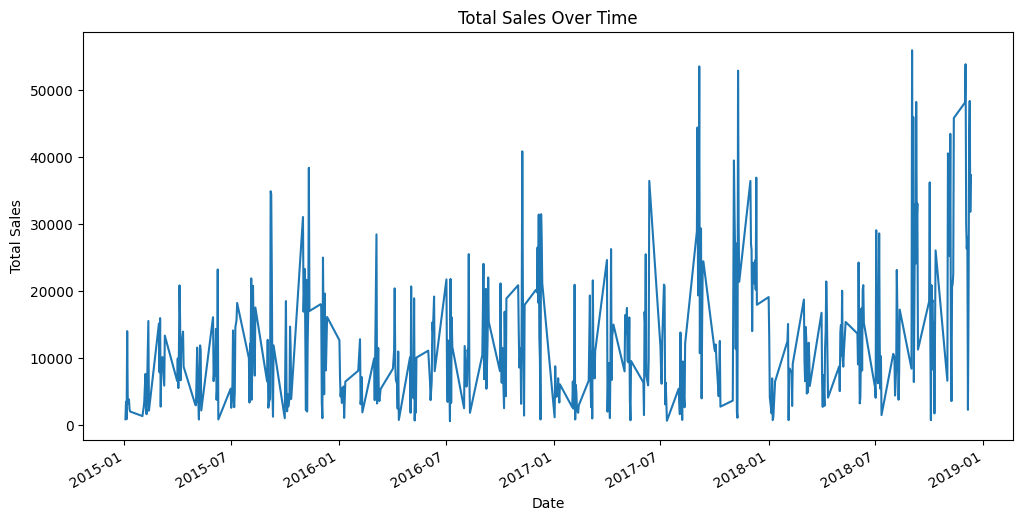

In [7]:
# Sales Trends Over Time

plt.figure(figsize=(12, 6))
data.groupby('Order Date')['Sales'].sum().plot()
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

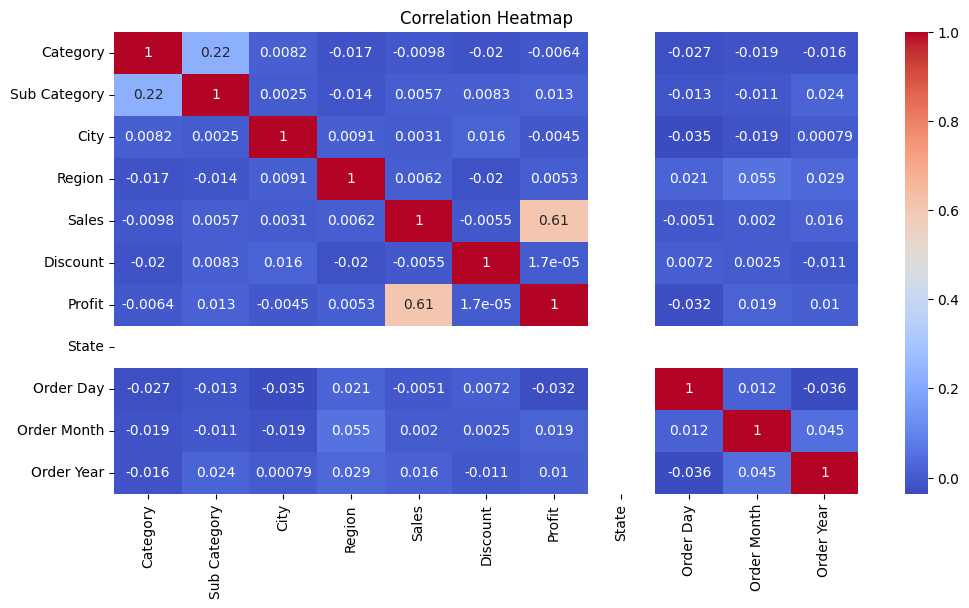

In [8]:
#Correlation Matrix

plt.figure(figsize=(12, 6))
corr_matrix = data.drop(columns=['Order ID']).corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

##Feature Engineering

In [9]:
# Step 5: Feature Engineering
data['Total Discount'] = data['Discount'] * data['Sales']
data['Profit Margin'] = data['Profit'] / (data['Sales'] + 1e-5)

##Feature Selection

In [10]:
# Select features and target variable
X = data.drop(columns=['Order ID', 'Customer Name','Order Date', 'Sales'])
y = data['Sales']

# Drop rows with NaN values
X.dropna(inplace=True)
y = y[X.index] # Align y with the filtered X

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Building Model :

In [11]:
# Initialize the model

model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=10, subsample=0.8, colsample_bytree=0.8, random_state=42)

# Train the model

model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Make predictions

ln_train_preds = model.predict(X_train)
rf_train_preds = rf_model.predict(X_train)
xgb_train_preds = xgb_model.predict(X_train)

ln_preds = model.predict(X_test)
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)

##Model Evaluation

In [12]:
# Step 9: Evaluation Function
def evaluate(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae_ = mean_absolute_error(y_true,y_pred)
    print(f"{name} = MSE: {mse:.2f} , R²: {r2:.4f}, MAE: {mae_:.2f}")

print("Training Performance:")
evaluate("Linear Regression -> Train", y_train, ln_train_preds)
evaluate("Random Forest     -> Train", y_train, rf_train_preds)
evaluate("XGBoost           -> Train", y_train, xgb_train_preds)
print("Testing Performance:")
evaluate("Linear Regression -> Test", y_test, ln_preds)
evaluate("Random Forest     -> Test", y_test, rf_preds)
evaluate("XGBoost           -> Test", y_test, xgb_preds)

Training Performance:
Linear Regression -> Train = MSE: 22781.07 , R²: 0.9306, MAE: 105.88
Random Forest     -> Train = MSE: 147.55 , R²: 0.9996, MAE: 8.93
XGBoost           -> Train = MSE: 170.25 , R²: 0.9995, MAE: 8.68
Testing Performance:
Linear Regression -> Test = MSE: 22058.99 , R²: 0.9341, MAE: 106.54
Random Forest     -> Test = MSE: 545.43 , R²: 0.9984, MAE: 16.42
XGBoost           -> Test = MSE: 3050.80 , R²: 0.9909, MAE: 42.34


In [13]:
data = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'Train R²': [0.9306, 0.9996, 0.9995],
    'Test R²': [0.9341, 0.9984, 0.9909],
    'Train MSE': [22781.07, 147.55, 170.25],
    'Test MSE': [22058.99, 545.43, 3050.80],
    'Train MAE': [105.88, 8.93, 8.68],
    'Test MAE': [106.54, 16.42, 42.34]
}

df = pd.DataFrame(data)
print(df)

               Model  Train R²  Test R²  Train MSE  Test MSE  Train MAE  \
0  Linear Regression    0.9306   0.9341   22781.07  22058.99     105.88   
1      Random Forest    0.9996   0.9984     147.55    545.43       8.93   
2            XGBoost    0.9995   0.9909     170.25   3050.80       8.68   

   Test MAE  
0    106.54  
1     16.42  
2     42.34  


In [14]:
index = np.arange(len(df['Model']))

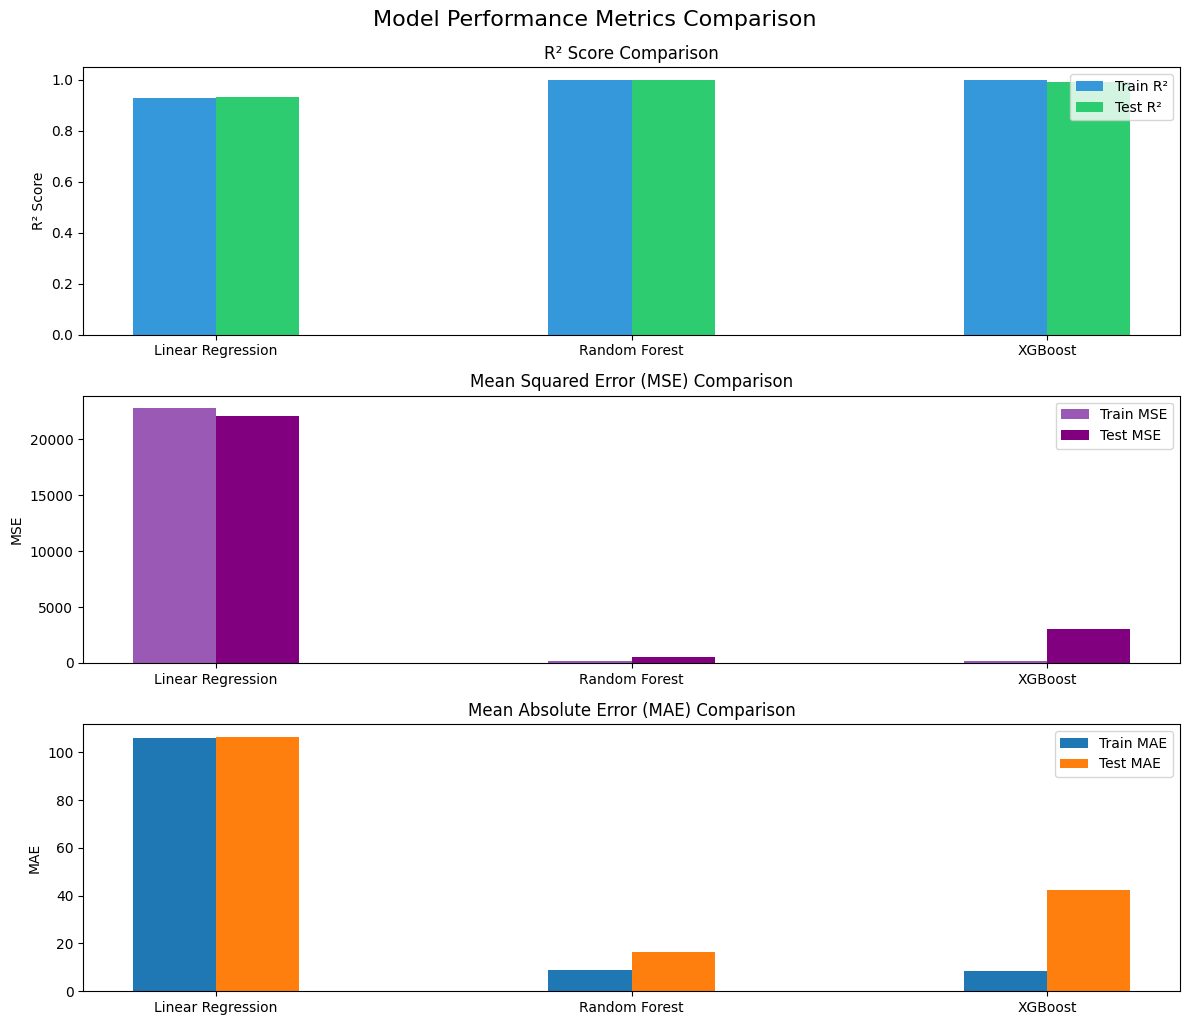

In [15]:
# Plotting
plt.figure(figsize=(12, 10))

# R² Score
plt.subplot(3, 1, 1)
plt.bar(index, df['Train R²'], width=0.2, label='Train R²', color='#3498db')
plt.bar(index + 0.2, df['Test R²'], width=0.2, label='Test R²', color='#2ecc71')
plt.xticks(index + 0.1, df['Model'])
plt.ylabel('R² Score')
plt.title('R² Score Comparison')
plt.legend()

# MSE
plt.subplot(3, 1, 2)
plt.bar(index, df['Train MSE'], width=0.2, label='Train MSE', color='#9b59b6')
plt.bar(index + 0.2, df['Test MSE'], width=0.2, label='Test MSE',color='purple')
plt.xticks(index + 0.1, df['Model'])
plt.ylabel('MSE')
plt.title('Mean Squared Error (MSE) Comparison')
plt.legend()

# MAE
plt.subplot(3, 1, 3)
plt.bar(index, df['Train MAE'], width=0.2, label='Train MAE')
plt.bar(index + 0.2, df['Test MAE'], width=0.2, label='Test MAE')
plt.xticks(index + 0.1, df['Model'])
plt.ylabel('MAE')
plt.title('Mean Absolute Error (MAE) Comparison')
plt.legend()

plt.tight_layout()
plt.suptitle('Model Performance Metrics Comparison', fontsize=16, y=1.02)
plt.show()


In [16]:
# Cross Validation

# Linear Regression
lr_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print(f"Linear Regression - CV R² Scores: {lr_scores}")
print(f"Linear Regression - Mean CV R²  : {lr_scores.mean():.4f}")

# Random Forest
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
print(f"Random Forest - CV R² Scores: {rf_scores}")
print(f"Random Forest - Mean CV R²  : {rf_scores.mean():.4f}")

# XGBoost
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')
print(f"XGBoost - CV R² Scores: {xgb_scores}")
print(f"XGBoost - Mean CV R²  : {xgb_scores.mean():.4f}")


Linear Regression - CV R² Scores: [0.93283838 0.93027737 0.92726706 0.92920204 0.93048691]
Linear Regression - Mean CV R²  : 0.9300
Random Forest - CV R² Scores: [0.99710933 0.99733896 0.99790183 0.99820048 0.99752263]
Random Forest - Mean CV R²  : 0.9976
XGBoost - CV R² Scores: [0.98879308 0.98712981 0.98709917 0.98978972 0.98951274]
XGBoost - Mean CV R²  : 0.9885


##Result

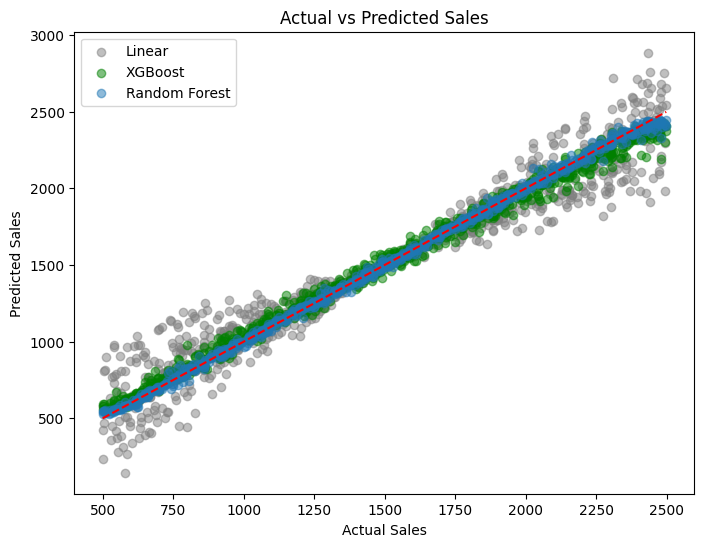

In [17]:
#Plot Actual vs Predicted Sales
plt.figure(figsize=(8,6))
plt.scatter(y_test, ln_preds, alpha=0.5, label='Linear', color='gray')
plt.scatter(y_test, xgb_preds, alpha=0.5, label='XGBoost', color='green')
plt.scatter(y_test, rf_preds, alpha=0.5, label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales")
plt.legend()
plt.show()